# Simulation study of Determinantal choice model

This notebook is an example of using Bayesian inference with the determinantal choice model for subset choice modeling on synthetic data.

In [32]:
import detit.models as dtm
import detit.quality
import detit.similarity
import detit.data
import simulation_tools as simu
import arviz as az
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.spatial import distance_matrix

In [33]:
# shortcuts
tfd = tfp.distributions
tfb = tfp.bijectors
dtype = tf.float64

# plotting settings
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

In [34]:
# experiment parameters
rng_u = np.random.default_rng(seed=26121991)
nItems = 15
nTrials = 1000  # nr trials
nTrain = 500 # trials used for training
nPoints = np.repeat(nItems, nTrials)  # points per tiral
minx, maxx = -2, 2 # box extent
radius = 2.3 # Matern thinning radius

## Sample synthetic data

Our first task is to sample some data. To do so we will generate ``nTrials`` trials. Each trial consits of a set of points. The points are sampled uniformly over a rectangle. We equip each points with four features: A constant, its x-coordinate, its y-coordinate, and its Euclidean distance to the origin.

The dependent variables are sampled using a two-stage thinning process. Initially all items, or points, have a positive ``True`` label. As points are thinned, their labels are set to ``False``. We first independently randomly thin each point in each trial with a probability depending on the features. This is (inhomogeneous) _Poisson thinning_.  Second, we apply _Matérn Type III thinning_ on the remaining points. This latter thinnning _dependent_, which induces _negative dependece_ in our labels. By varying the degree of negative dependence (via the ``radius`` discussed soon), we can investigate the perormance of various subset choice and / or classification models.

In [35]:
# sample points in rectangles
lons = [rng_u.uniform(minx, maxx, size=n) for n in nPoints] # X-coords
lats = [rng_u.uniform(minx, maxx, size=n) for n in nPoints] # Y-coords
points = [np.vstack([lons[i], lats[i]]).T for i in range(nTrials)] 

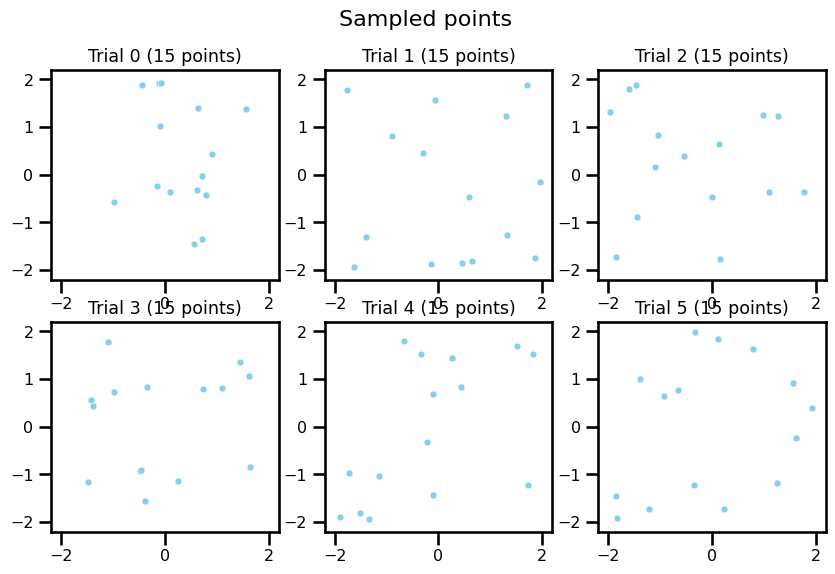

In [36]:
# make lists of arrays and plot
Xs = []
for i in range(nTrials):
    #Xs.append(np.vstack((np.ones(nPoints[i]), np.sqrt(lons[i]**2 + lats[i]**2), lats[i])).T)
    Xs.append(np.vstack((np.ones(nPoints[i]), np.sqrt(lons[i]**2 + lats[i]**2), lats[i], lons[i])).T)
Zs = []
for i in range(nTrials):
    Zs.append([distance_matrix(points[i], points[i])])

simu.plot_points(points, 0, title="Sampled points")

The figure above shows the locations of points for 6 trials. The points are distirubted uniformly.

We next beging deriving the labels by first subjecting our points to one round of _independent thinning_. Each point $u \in B$ is retained with probability
$$p(u) = \exp\{\beta_0 + x_1(u)\cdot \beta_1\}$$
where $x(u)$ is the distance of point $u$ to the origin and $(\beta_0, \beta1)$ are parameters of our choosing. Below we use $\beta_1 > 0$ so that points further from the origin are more likely to be retained.


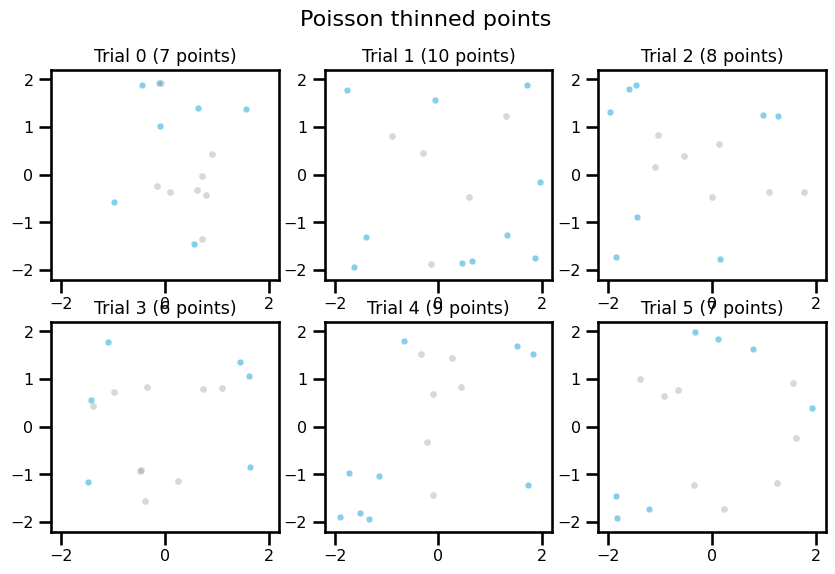

In [37]:
# poisson thinning
rng_t = np.random.default_rng(seed=18842524)
beta0 = -5.0
beta1 = 2.5

# thinned labels
labels = [np.ones(shape=n).astype(bool) for n in nPoints] # all labels are 1
probs = [np.exp(beta0 + X[:, 1]*beta1) for X in Xs]
unifs = [rng_t.uniform(0, 1, size=n) for n in nPoints] 
retain = [(unifs[i] < probs[i]) for i in range(nTrials)]
labels = [labels[i] * retain[i] for i in range(nTrials)]

simu.plot_points(points, 0.0, labels=labels, title="Poisson thinned points")

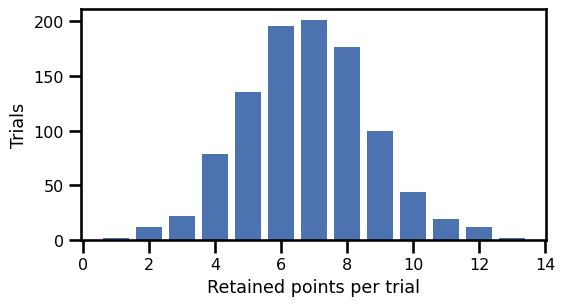

In [38]:
# histogram of nr points
n_pts = [label.sum() for label in labels]
unique, counts = np.unique(n_pts, return_counts=True)
fig, ax = plt.subplots(figsize=(6, 3))
plt.bar(unique, height=counts)
plt.xlabel("Retained points per trial")
plt.ylabel("Trials")
plt.show()

Finally, _Matérn Type III_ thinning is applied to the remaining points. This type of thinnning is deterministic and dependnet. There is a fixed radius $r > 0$ and each points $u \in B$ is equipped with a _mark_ $m(u)$. Points are processed the order of decreasing marks. When a point $u$ is processed, it is labeled as ``False`` if there is a point within distance at most $2r$ that has a larger mark. Otherwise the label ``True`` is retained. One can visualize the retention process by drawing radius $r$ cores around each point. No pair of ``True``-labeled points can have overlapping cores; in the case of a conflict the point with the larger mark retains its ``True``-label.

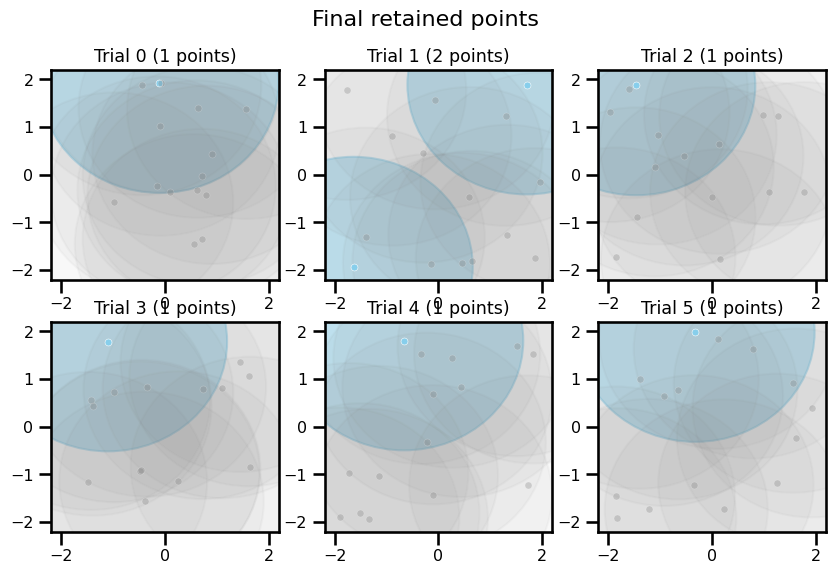

In [39]:
# sample and plot matern
labels = [simu.sample_matern_iii(Xs[i][:, 2], Zs[i][0], radius, labels=labels[i]) for i in range(nTrials)]
simu.plot_points(points, radius, labels=labels, title="Final retained points")

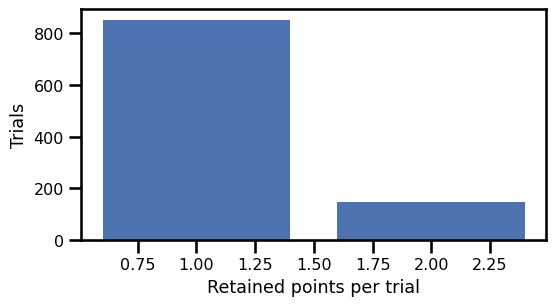

In [40]:
# histogram of nr points
n_pts = [label.sum() for label in labels]
unique, counts = np.unique(n_pts, return_counts=True)
fig, ax = plt.subplots(figsize=(6,3))
plt.bar(unique, height=counts)
plt.xlabel("Retained points per trial")
plt.ylabel("Trials")
plt.show()

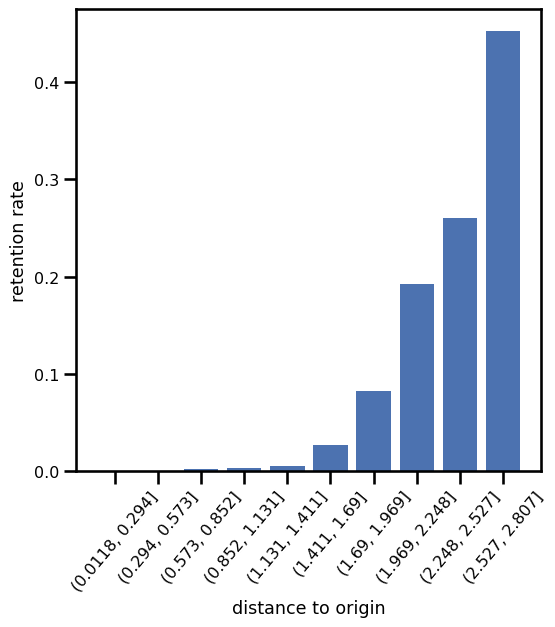

In [41]:
# plot x-bins vs percentage included
data = np.array([X[:, 1] for X in Xs]).flatten()
outs = np.array(labels).flatten()  # outcomes array
df = pd.DataFrame(data={'x':data, 'outcome':outs})
df['bin'] = pd.cut(df['x'], bins=10)

# make data
rows = df.groupby('bin')['outcome'].mean().index.astype(str).values
heights = df.groupby('bin')['outcome'].mean().values

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=rows, height=heights)
ax.set_ylabel('retention rate')
ax.set_xlabel('distance to origin')
plt.xticks(rotation=50);

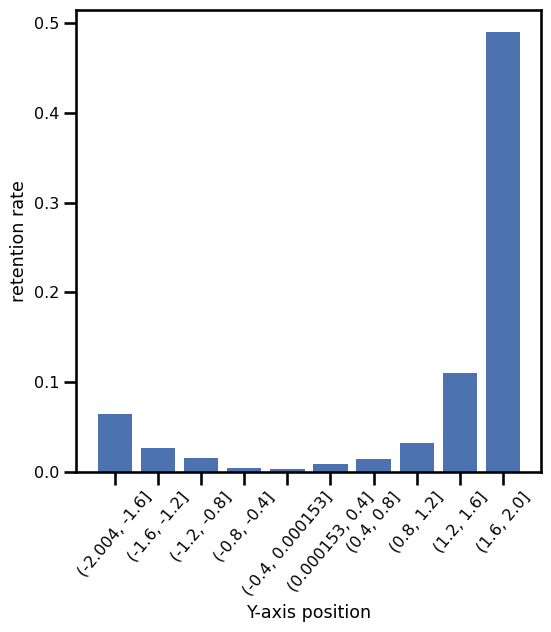

In [42]:
# plot x-bins vs percentage included
data = np.array([X[:, 2] for X in Xs]).flatten()
outs = np.array(labels).flatten()  # outcomes array
df = pd.DataFrame(data={'x':data, 'outcome':outs})
df['bin'] = pd.cut(df['x'], bins=10)

# make data
rows = df.groupby('bin')['outcome'].mean().index.astype(str).values
heights = df.groupby('bin')['outcome'].mean().values

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=rows, height=heights)
ax.set_ylabel('retention rate')
ax.set_xlabel('Y-axis position')
plt.xticks(rotation=50);

## Specify a determinantal choice model

### Preparing the data

The data must be given in a particular form, namely two ``tf.data.Datasets``; one for the full data, one for the subsetted data containing only retained points (i.e. "selected" items). This is accomplished using the ``detit.data.Dataset`` object, which we can generate from lists of numpy arrays.

In [43]:
# make arrays
Zs = [np.array(Z).T for Z in Zs] # entries must be (nItems, nItems, nDims)

# extract training data
Xs_train = Xs[:nTrain]
Zs_train = Zs[:nTrain]
labels_train = labels[:nTrain]

Xs_test = Xs[nTrain:]
Zs_test = Zs[nTrain:]
labels_test = labels[nTrain:]

dsTrain = detit.data.Dataset.fromNumpy(labels=labels_train, Xs=Xs_train, Zs=Zs_train)

Let's look inside the ``Datset``-object. It has to components ``.succ`` and ``.full`` correspoding to the subset of selected items, and the full sets of items, respectively. While this includes some duplicated data, it helps simplify computation. Each sub-dataset is a ``tensorflow.data.Dataset`` in which trials have been batched by the number of items. Thus, when the number of unique batch sizes is modest, we can efficiently process all data.

In [44]:
# explore batches
print("Data batches of selected subsets:")
for ele in dsTrain.succ:
    print(f"A {ele[2].shape}-tensor represents {ele[0][0]}-item batches.")
print("Data batches of full sets:")
for ele in dsTrain.full:
    print(f"A {ele[2].shape}-tensor represents {ele[0][0]}-item batches.")

Data batches of selected subsets:
A (416, 1, 1, 1)-tensor represents 1-item batches.
A (84, 2, 2, 1)-tensor represents 2-item batches.
Data batches of full sets:
A (500, 15, 15, 1)-tensor represents 15-item batches.


### Specifying the likelihood model

In [45]:
# specify L-ensemble via quality and similarity
quality = detit.quality.Exponential()
similarity = detit.similarity.RBF()

ensemble = dtm.Ensemble(quality, similarity)

### Specifying a prior model

In [46]:
# prior over beta
nDimsQual = Xs_train[0].shape[-1]
nDimsSimi = Zs_train[0].shape[-1]
nDims = nDimsQual + nDimsSimi

prior_loc = tf.constant(np.zeros(nDimsQual), dtype=dtype)
prior_scale = tf.constant(np.repeat(10, nDimsQual), dtype=dtype)

# make prior
prior_beta = tfd.Normal(loc=prior_loc, scale=prior_scale)

# make into multivariate (independent) prior
prior_beta = tfd.Independent(distribution=prior_beta, reinterpreted_batch_ndims=1)
print(prior_beta)

# prior over ell (log-normal)
loc = tf.constant([-1], dtype=dtype)
scale = tf.constant([1.25], dtype=dtype)
prior_ell = tfd.Normal(loc, scale, validate_args=True, allow_nan_stats=True)
prior_ell = tfd.Independent(distribution=prior_ell, reinterpreted_batch_ndims=1)

print(prior_ell)

# get a joint prior
joint_prior = tfd.JointDistributionSequential([prior_beta, prior_ell],
                                              batch_ndims=0, use_vectorized_map=True)
prior = tfd.Blockwise(joint_prior)
print(prior)

tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[4], dtype=float64)
tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[1], dtype=float64)
tfp.distributions._Blockwise("Blockwise", batch_shape=[], event_shape=[5], dtype=float64)


### Attach data and make functional closure of posterior likelihood
Having a simple function that takes only a full parameter tenor as input is helpful for condcting inference. To do this the ``Ensemble``-object has a ``likelihoodClosure``-method. You pass it a ``Dataset`` of training data, the number of dimensions that are passed to the quality model, and an optional ``prior``. It returns a log-likelihood (or log-posterior likelihood in the case a prior was given) function that takes only a ``parameters`` argument, and returns the log-likelihood of the dataset at the given parameters. The first ``nDimsQual`` dimensions of the ``parameters`` tensor are assumed to be the quality model parameters.

In [47]:
# get our log-probability function
log_posterior = ensemble.likelihoodClosure(dsTrain, nDimsQual, prior)

In [48]:
# test function and gradient call
params = tf.constant([[1, 0, 0, 0, -1], [1, 1, 1, 1, -2]], dtype=dtype) # [b0, b1, b2, b3, ell]
#params = tf.constant([[2, 1, 1, 2], [1, 1, 1, 1]], dtype=dtype) # [b0, b1, b2, b3, ell]
[funval, grads] = tfp.math.value_and_gradient(log_posterior, params)
print("Function Value: ", funval)
print('Gradient: \n', grads)

Function Value:  tf.Tensor([ -8549.5898948  -17473.12576534], shape=(2,), dtype=float64)
Gradient: 
 tf.Tensor(
[[-4415.55122682 -6340.44045277   770.30796981   -60.44340029
   1260.94086982]
 [-5730.69666763 -8371.58760815   -20.23952631  -925.76336373
    393.19768237]], shape=(2, 5), dtype=float64)


## Bayesian inference

In [49]:
# Setup NUTS for Bayesian inference
nChains = 25
nBurnin = 1000
nResults = 1000
nDims = nDimsQual + nDimsSimi
rng_p = np.random.default_rng(seed=3545412092) # dedicated rng
print(f"Set {nChains} chains and {nDims} parameter dimensions.")

Set 25 chains and 5 parameter dimensions.


In [50]:
# make initial state
lows = np.array([-2, -2, -2, 2, -2.5])
upps = np.array([2, 2, 2, 2, -1.5])
params_init = rng_p.uniform(lows, upps, size=(nChains, nDims))
initial_state = tf.constant(params_init, dtype=dtype)

# test eval    
[funval, grads] = tfp.math.value_and_gradient(log_posterior, params)

In [51]:
# transition kernel
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn = log_posterior,
  step_size = 0.15,
  num_leapfrog_steps = 1
)

# adaptive rule for inner kernel stepsize
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps = int(nBurnin * 0.8)
)

#@tf.function - Code as is now does not support tracing...
def run_chain(initial_state, num_results=5000, num_burnin_steps=0):
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda current_state, kernel_results: kernel_results)

In [52]:
# run chain & get results
samples, kernel_results = run_chain(initial_state, nResults, nBurnin)

In [53]:
# summaries
results = samples.numpy().T
data = az.convert_to_dataset({'beta0': results[0, :],
                              'beta1': results[1, :],
                              'beta2': results[2, :],
                              'beta3': results[3, :],
                              'logls': results[3, :]}
                              )

# get log accept ratio
log_accept_ratio = kernel_results.inner_results.log_accept_ratio
p_accept = tf.math.exp(tfp.math.reduce_logmeanexp(tf.minimum(log_accept_ratio, 0.)))
print("Acceptance ratio: \t %.3f" % p_accept.numpy())

Acceptance ratio: 	 0.777


In [54]:
# effective sample size
print(az.ess(data)['beta0'].values)
print(az.ess(data)['beta1'].values)
print(az.ess(data)['beta2'].values)
print(az.ess(data)['beta3'].values)
print(az.ess(data)['logls'].values)

31.007171176861707
78.61530876631481
1946.3931696675693
10446.702307978258
10446.702307978258


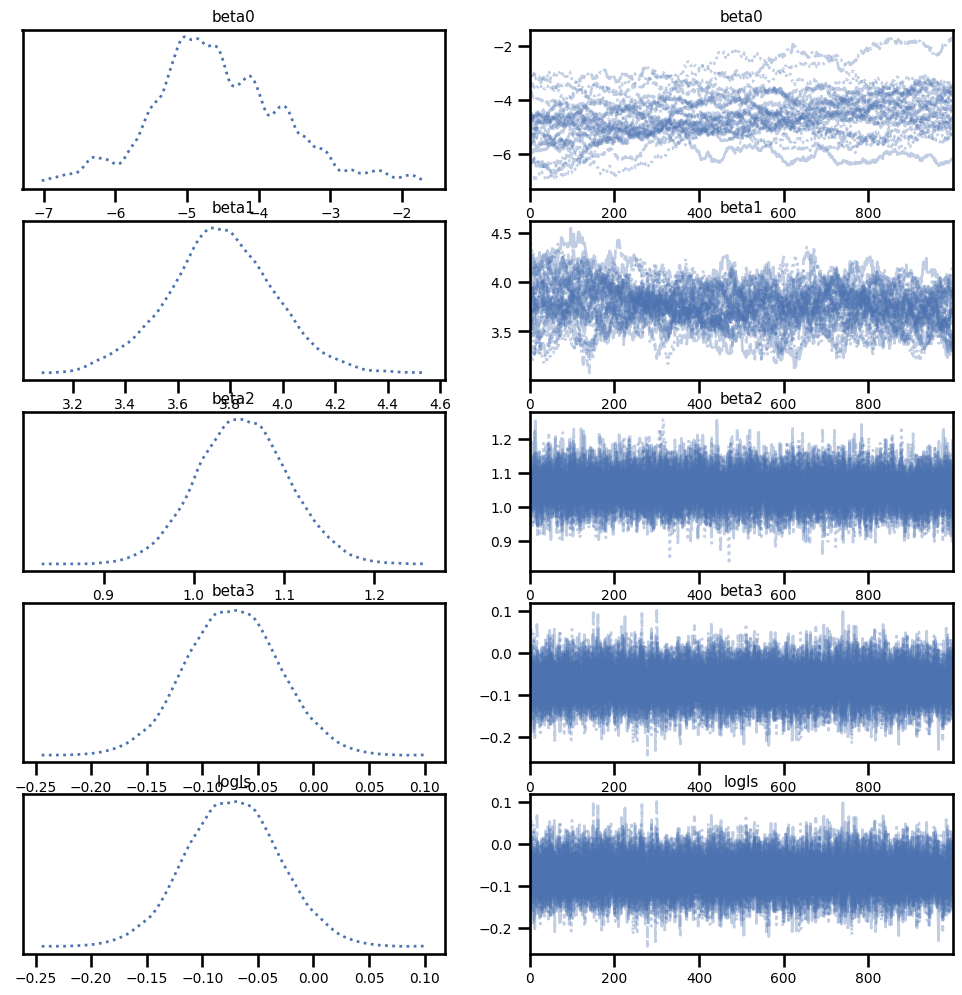

In [55]:
# trace plot
axes = az.plot_trace(data, combined=True, compact=True, figsize=(12, 12))
fig = axes.ravel()[0].figure
fig.savefig(f'plots/mnlogit/traceplot_{nItems}_{radius}.png')

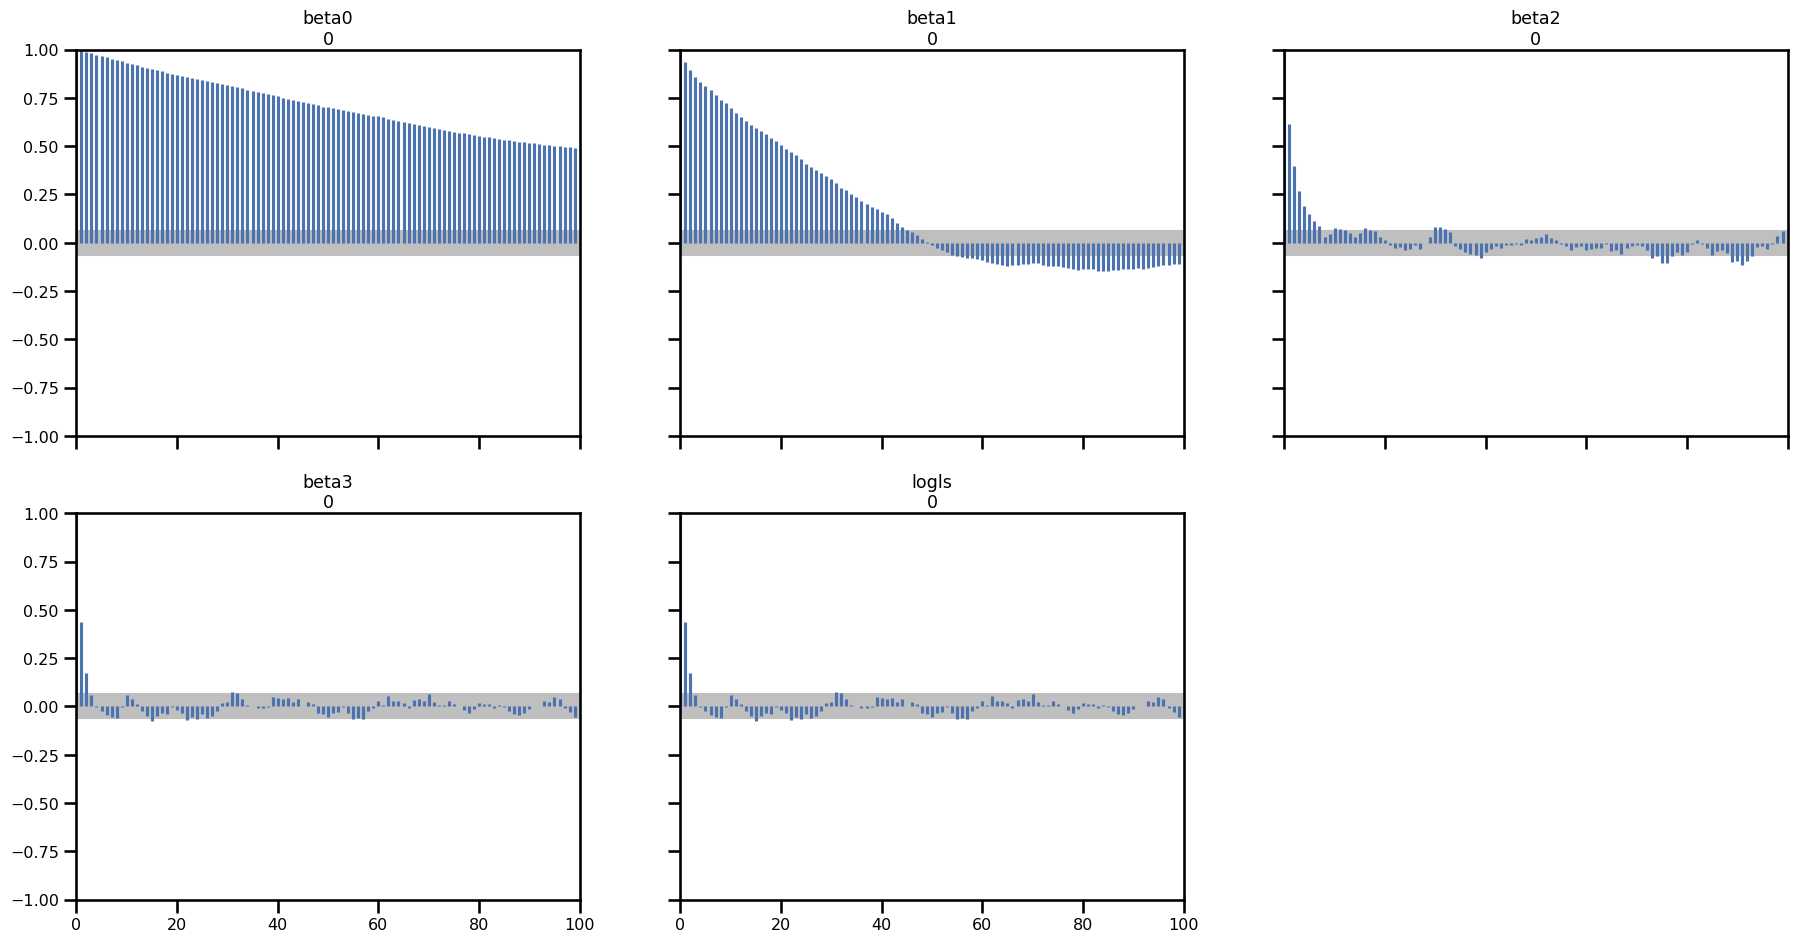

In [56]:
# autocorrelation plots
axes = az.plot_autocorr(data.sel(chain=[0]))
fig = axes.ravel()[0].figure
fig.savefig(f'plots/detit/autrocorrelation_{nItems}_{radius}.png')
plt.show()

In [57]:
# save R-hat output
az.rhat(data).to_netcdf(f'data/detit/rhat_{nItems}_{radius:.2f}.json')

## Predictions

In [58]:
# collect betas
params = samples[-1, :, :]
print(params.shape)

# make testing data to tensorts and expand dims for batch dimension
Xs_test = detit.data.toTensors(Xs_test)
Zs_test = detit.data.toTensors(Zs_test)
Xs_test = [tf.expand_dims(X, axis=0) for X in Xs_test]
Zs_test = [tf.expand_dims(Z, axis=0) for Z in Zs_test]


(25, 5)


In [59]:
# form predictions
rng = np.random.default_rng(20122221201)
nTest = nTrials - nTrain
predictions = np.zeros(shape=(nChains, nItems, nTest))

# form [nChains, nTest, nItems, nItems] tensor of L-ensembles
Ls = [ensemble(params[:, :nDimsQual], params[:, nDimsQual:], X, Z) for X, Z in zip(Xs_test, Zs_test)]

for chain in range(nChains):
    for trial in range(nTest):
        L = Ls[trial][chain, 0, ...].numpy()
        K = np.eye(nItems) - np.linalg.inv(np.eye(nItems) + L)
        selection = simu.dpp_sampler_generic_kernel(K, rng)
        # label selected items with ones
        for item in selection:
            predictions[chain, item, trial] = 1

In [60]:
# save predictions
folder = 'data/detit/'
save_predictions = predictions.reshape(nChains, nItems * nTest) # reshape to 2D
np.savetxt(folder + f"pred_{nItems}_items_rad{radius:.1f}.csv", save_predictions, delimiter=",")

## Summarize results

In [61]:
# read  dredictions
folder = 'data/detit/'
res = np.genfromtxt(folder + f"pred_{nItems}_items_rad{radius:.1f}.csv", delimiter=",", usemask=False)
res = res.reshape((nChains, nItems, nTest)) # reshape back to original

# get testing data
y_test = np.array(labels[nTrain:])

# compute summary
print(simu.summarize_mcc(res, y_test))

(0.3514313614845264, 0.01947904049072263)
